## Plot-ATL11-Tidal-Histograms

Calculates histograms of ICESat-2 land ice elevation differences corrected for different tide models over Antarctic ice shelves

#### Python Dependencies
- [numpy: Scientific Computing Tools For Python](https://numpy.org)
- [scipy: Scientific Tools for Python](https://docs.scipy.org/doc/)
- [h5py: Python interface for Hierarchal Data Format 5 (HDF5)](https://h5py.org)
- [pyproj: Python interface to PROJ library](https://pypi.org/project/pyproj/)
- [matplotlib: Python 2D plotting library](http://matplotlib.org/)

#### Program Dependencies
- read_ICESat2_ATL11.py: reads ICESat-2 annual land ice height data files
- time.py: utilities for calculating time operations

#### Load necessary modules for running the notebook

In [1]:
from __future__ import print_function

import os
import re
import pyproj
import datetime
import numpy as np
import scipy.stats
import matplotlib
matplotlib.rcParams['axes.linewidth'] = 2.0
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = ['Helvetica']
import matplotlib.pyplot as plt
import matplotlib.offsetbox
import ipywidgets as widgets
from icesat2_toolkit.read_ICESat2_ATL11 import read_HDF5_ATL11,read_HDF5_ATL11_pair
import icesat2_toolkit.time

In /localhome/tyler/local/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /localhome/tyler/local/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /localhome/tyler/local/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /localhome/tyler/local/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /localhome/tyler/local/lib/python3.8/site-packages/matplo

#### Get current list of available cycles

In [2]:
def cycles():
    cycle_length = 2
    # number of GPS seconds between the GPS epoch and ATLAS SDP epoch
    atlas_sdp_gps_epoch = 1198800018.0
    # number of GPS seconds since the GPS epoch for first ATLAS data point
    atlas_gps_start_time = atlas_sdp_gps_epoch + 24710205.39202261
    epoch1 = datetime.datetime(1980,1,6,0,0,0)
    epoch2 = datetime.datetime(1970,1,1,0,0,0)
    # get the total number of seconds since the start of ATLAS and now
    delta_time_epochs = (epoch2 - epoch1).total_seconds()
    atlas_UNIX_start_time = (atlas_gps_start_time - delta_time_epochs)
    present_time = datetime.datetime.now().timestamp()
    # divide total time by cycle length to get the maximum number of orbital cycles
    ncycles = np.ceil((present_time - atlas_UNIX_start_time)/(86400*91)).astype('i')
    return [str(c+1).zfill(cycle_length) for c in range(ncycles)]

#### Set working data directory and histogram parameters

In [9]:
# regional plot parameters
# x and y limit (in projection)
region_xlimit = {}
region_ylimit = {}
# Antarctica (AIS)
region_xlimit['AIS'] = (-3100000,3100000)
region_ylimit['AIS'] = (-2600000,2600000)
# Ronne/Filchner Ice Shelf
region_xlimit['FRIS'] = (-1535000,-520000)
region_ylimit['FRIS'] = (77500,1092500)
# Ross Ice Shelf
region_xlimit['RIS'] = (-740000,520000)
region_ylimit['RIS'] = (-1430000,-300000)
# Amery Ice Shelf
region_xlimit['AMIS'] = (1630000,2310000)
region_ylimit['AMIS'] = (530000,880000)
# Larsen-C Ice Shelf
region_xlimit['LCIS'] = (-2470000,-2050000)
region_ylimit['LCIS'] = (895000,1325000)
# Larsen-D Ice Shelf
region_xlimit['LDIS'] = (-2130000,-1595000)
region_ylimit['LDIS'] = (880000,1165000)
# George VI Ice Shelf
region_xlimit['G6IS'] = (-2230000,-1685000)
region_ylimit['G6IS'] = (320000,830000)
# Abbot Ice Shelf
region_xlimit['ABIS'] = (-2000000,-1800000)
region_ylimit['ABIS'] = (-460000,100000)
# Pine Island Ice Shelf
region_xlimit['PIIS'] = (-1695000,-1510000)
region_ylimit['PIIS'] = (-380000,-230000)
# Thwaites Glacier Tongue
region_xlimit['THWGT'] = (-1630000,-1480000)
region_ylimit['THWGT'] = (-525000,-370000)
# Dotson/Crosson Ice Shelf
region_xlimit['DCIS'] = (-1640000,-1460000)
region_ylimit['DCIS'] = (-715000,-525000)
# Wilkins Ice Shelf
region_xlimit['WLKIS'] = (-2180000,-1900000)
region_ylimit['WLKIS'] = (530000,795000)
# Wordie (Prospect) Ice Shelf
region_xlimit['WRDIS'] = (-2115000,-2042500)
region_ylimit['WRDIS'] = (830000,895000)
# Venable Ice Shelf
region_xlimit['VBLIS'] = (-1895000,-1800000)
region_ylimit['VBLIS'] = (22000,151000)

# set the directory with ICESat-2 data
dirText = widgets.Text(
    value=os.getcwd(),
    description='Directory',
    disabled=False
)
# set the ICESat-2 ATL11 data release
releaseDropdown = widgets.Dropdown(
    options=['001','002'],
    value='002',
    description='Release',
    disabled=False
)
# set the ICESat-2 start and end cycles
all_cycles = cycles()
cycleSelect = widgets.SelectionRangeSlider(
    options=all_cycles,
    index=(2,len(all_cycles)-1),
    description='Cycles',
    disabled=False
)
# set the ICESat-2 granule regions
granuleSelect = widgets.SelectMultiple(
    options=np.arange(1,15),
    value=[10,11,12],
    description='Granules',
    disabled=False
)
# set the region to calculate histograms
regions = region_xlimit.keys()
regionDropdown = widgets.Dropdown(
    options=regions,
    value='FRIS',
    description='Region',
    disabled=False
)
# set the differencing method for histograms
methodDropdown = widgets.Dropdown(
    options=['AT','XT'],
    value='AT',
    description='Method',
    disabled=False
)

# display widgets for setting parameters
widgets.VBox([dirText,releaseDropdown,cycleSelect,granuleSelect,
    regionDropdown,methodDropdown])

#### Find indices of common reference points between two lists
Determines which along-track points correspond with the across-track

In [4]:
def common_reference_points(XT, AT):
    ind2 = np.squeeze([np.flatnonzero(AT == p) for p in XT])
    return ind2

In [16]:
# get values from widgets
base_dir = os.path.expanduser(dirText.value)
RELEASE = releaseDropdown.value
CYCLES = cycleSelect.value
GRANULES = granuleSelect.value
REGION = regionDropdown.value
# read crossovers from ATL11 files
METHOD = methodDropdown.value
CROSSOVERS = (METHOD == 'XT')
# tide models to use
TIDE_MODELS = ['CATS2008','TPXO9-atlas-v3','GOT4.10','FES2014']
# height threshold (filter points below 0m elevation)
THRESHOLD = 0.0
# time threshold for crossover differences
DAYS = 10.0

# histogram parameters
w = 0.01
vmin,vmax=(-8,8)
b1 = np.arange(vmin,vmax+w,w)
b2 = (b1[1:] + b1[0:-1])/2.0
nbins = np.int((vmax-vmin)/w)
# total difference histogram for each tide model
hist = dict(Uncorrected=np.zeros((nbins)))
for m in TIDE_MODELS:
    hist[m] = np.zeros((nbins))

# find ICESat-2 HDF5 files in the subdirectory for product and release
regex_track = '|'.join(['{0:04d}'.format(T) for T in range(1,1388)])
regex_granule = '|'.join(['{0:02d}'.format(G) for G in GRANULES])
# compile regular expression operator for extracting data from files
args = (regex_track,regex_granule,CYCLES[0],CYCLES[1],RELEASE)
regex_pattern = (r'(processed_)?(ATL\d{{2}})_({0})({1})_({2})({3})_'
    r'({4})_(\d{{2}})(.*?).h5$')
rx = re.compile(regex_pattern.format(*args), re.VERBOSE)
# associated file format
file_format = '{0}_{1}_{2}_{3}{4}_{5}{6}_{7}_{8}{9}.h5'
# HDF5 group name for across-track data
XT = 'crossing_track_data'

# projections for converting lat/lon to polar stereographic
crs1 = pyproj.CRS.from_string("epsg:{0:d}".format(4326))
crs2 = pyproj.CRS.from_string("epsg:{0:d}".format(3031))
transformer = pyproj.Transformer.from_crs(crs1, crs2, always_xy=True)

# find all input ATL11 files
FILE1 = [os.path.join(base_dir,f) for f in os.listdir(base_dir)
    if bool(rx.match(f))]
# total number of valid segments for differencing method
total_valid = 0
# for each file in the cycle
for f1 in sorted(FILE1):
    # extract parameters from file
    SUB,PRD,TRK,GRAN,SCYC,ECYC,RL,VERS,AUX = rx.findall(f1).pop()
    # read ICESat-2 file
    try:
        mds1,attrs1,pairs1 = read_HDF5_ATL11(f1, VERBOSE=True,
            ATTRIBUTES=True, CROSSOVERS=CROSSOVERS)
    except:
        continue

    # for each beam in the file
    for ptx in pairs1:
        # extract along-track and across-track variables
        ref_pt = {}
        latitude = {}
        longitude = {}
        delta_time = {}
        h_corr = {}
        quality_summary = {}
        tide_ocean = {m:{} for m in TIDE_MODELS}
        ib = {}
        groups = ['AT']
        # shape of along-track data
        n_points,n_cycles = mds1[ptx]['delta_time'].shape
        # along-track (AT) reference point, latitude, longitude and time
        ref_pt['AT'] = mds1[ptx]['ref_pt'].copy()
        latitude['AT'] = np.ma.array(mds1[ptx]['latitude'],
            fill_value=attrs1[ptx]['latitude']['_FillValue'])
        latitude['AT'].mask = (latitude['AT'] == latitude['AT'].fill_value)
        longitude['AT'] = np.ma.array(mds1[ptx]['longitude'],
            fill_value=attrs1[ptx]['longitude']['_FillValue'])
        longitude['AT'].mask = (longitude['AT'] == longitude['AT'].fill_value)
        delta_time['AT'] = np.ma.array(mds1[ptx]['delta_time'],
            fill_value=attrs1[ptx]['delta_time']['_FillValue'])
        delta_time['AT'].mask = (delta_time['AT'] == delta_time['AT'].fill_value)
        # corrected height
        h_corr['AT'] = np.ma.array(mds1[ptx]['h_corr'],
            fill_value=attrs1[ptx]['h_corr']['_FillValue'])
        h_corr['AT'].mask = (h_corr['AT'] == h_corr['AT'].fill_value)
        # quality summary
        quality_summary['AT'] = (mds1[ptx]['quality_summary'] == 0)
        # ocean corrections
        for m in TIDE_MODELS:
            tide_ocean[m]['AT'] = np.ma.zeros((n_points,n_cycles),
                fill_value=attrs1[ptx]['cycle_stats']['tide_ocean']['_FillValue'])
            tide_ocean[m]['AT'].mask = np.zeros((n_points,n_cycles),dtype=bool)
        ib['AT'] = np.ma.array(mds1[ptx]['cycle_stats']['dac'],
            fill_value=attrs1[ptx]['cycle_stats']['dac']['_FillValue'])
        ib['AT'].mask = (ib['AT'] == ib['AT'].fill_value)
        # if running ATL11 crossovers
        if CROSSOVERS:
            # add to group
            groups.append('XT')
            # shape of across-track data
            n_cross, = mds1[ptx][XT]['delta_time'].shape
            # across-track (XT) reference point
            ref_pt['XT'] = mds1[ptx][XT]['ref_pt'].copy()
            # across-track (XT) latitude, longitude and time
            latitude['XT'] = np.ma.array(mds1[ptx][XT]['latitude'],
                fill_value=attrs1[ptx][XT]['latitude']['_FillValue'])
            latitude['XT'].mask = (latitude['XT'] == latitude['XT'].fill_value)
            longitude['XT'] = np.ma.array(mds1[ptx][XT]['longitude'],
                fill_value=attrs1[ptx][XT]['longitude']['_FillValue'])
            latitude['XT'].mask = (latitude['XT'] == longitude['XT'].fill_value)
            delta_time['XT'] = np.ma.array(mds1[ptx][XT]['delta_time'],
                fill_value=attrs1[ptx][XT]['delta_time']['_FillValue'])
            delta_time['XT'].mask = (delta_time['XT'] == delta_time['XT'].fill_value)
            # corrected height
            h_corr['XT'] = np.ma.array(mds1[ptx][XT]['h_corr'],
                fill_value=attrs1[ptx][XT]['h_corr']['_FillValue'])
            h_corr['XT'].mask = (h_corr['XT'] == h_corr['XT'].fill_value)
            # quality summary
            quality_summary['XT'] = (mds1[ptx][XT]['atl06_quality_summary'] == 0)
            # ocean corrections
            for m in TIDE_MODELS:
                tide_ocean[m]['XT'] = np.ma.zeros((n_cross),
                    fill_value=attrs1[ptx][XT]['tide_ocean']['_FillValue'])
                tide_ocean[m]['XT'].mask = np.zeros((n_cross),dtype=bool)
            ib['XT'] = np.ma.array(mds1[ptx][XT]['dac'],
                fill_value=attrs1[ptx][XT]['dac']['_FillValue'])
            ib['XT'].mask = (ib['XT'] == ib['XT'].fill_value)

        # ice shelf mask
        a2 = (PRD,'ICE_SHELF','MASK',TRK,GRAN,SCYC,ECYC,RL,VERS,AUX)
        f2 = os.path.join(base_dir,file_format.format(*a2))
        # create data mask for ice shelves
        mds1[ptx]['subsetting'] = {}
        mds1[ptx]['subsetting'].setdefault('ice_shelf',
            np.zeros((n_points),dtype=bool))
        # check that mask file exists
        try:
            mds2,attr2 = read_HDF5_ATL11_pair(f2,ptx,
                VERBOSE=False,SUBSETTING=True)
        except:
            continue
        else:
            mds1[ptx]['subsetting']['ice_shelf'] = \
                mds2[ptx]['subsetting']['ice_shelf']

        # read height corrections from each tide model
        for m in TIDE_MODELS:
            # tide model
            a3 = (PRD,m,'TIDES',TRK,GRAN,SCYC,ECYC,RL,VERS,AUX)
            f3 = os.path.join(base_dir,file_format.format(*a3))
            # check that tide file exists
            try:
                mds3,attr3 = read_HDF5_ATL11_pair(f3,ptx,
                    VERBOSE=False,CROSSOVERS=CROSSOVERS)
            except:
                # mask all values
                for group in groups:
                    tide_ocean[m][group].mask[:] = True
                continue
            else:
                tide_ocean[m]['AT'].data[:] = \
                        mds3[ptx]['cycle_stats']['tide_ocean']
                if CROSSOVERS:
                    tide_ocean[m]['XT'].data[:] = \
                        mds3[ptx][XT]['tide_ocean']
            # set masks and fill values
            for group,val in tide_ocean[m].items():
                val.mask[:] = (val.data == val.fill_value)
                val.data[val.mask] = val.fill_value

        #-- check method of differencing
        if (METHOD == 'AT'):
            # if running along-track differences
            difference_cycles = np.arange(n_cycles-1)
            n_diff = np.copy(n_points)
            # convert lat/lon to polar stereographic
            X,Y = transformer.transform(longitude['AT'],latitude['AT'])
            # run for all indices
            ref_indices = Ellipsis
        elif (METHOD == 'XT'):
            # if running crossovers
            difference_cycles = np.arange(n_cycles)
            n_diff = np.copy(n_cross)
            # convert lat/lon to polar stereographic
            X,Y = transformer.transform(longitude['XT'],latitude['XT'])
            # find mapping between crossover and along-track reference points
            ref_indices = common_reference_points(ref_pt['XT'], ref_pt['AT'])
        else:
            difference_cycles = []
        # for each cycle
        for cycle in difference_cycles:
            # fill value for invalid values
            fv = attrs1[ptx]['h_corr']['_FillValue']
            # copy annual land ice height variables
            h1 = np.ma.array(mds1[ptx]['h_corr'][ref_indices,cycle],
                fill_value=fv)
            if CROSSOVERS:
                h2 = np.ma.array(mds1[ptx][XT]['h_corr'][:],
                    fill_value=fv)
            else:
                h2 = np.ma.array(mds1[ptx]['h_corr'][:,cycle+1],
                    fill_value=fv)

            # create masks for height variables
            h1.mask = (h1.data == h1.fill_value)
            h2.mask = (h2.data == h2.fill_value)

            # # reference heights to geoid
            # h1 -= mds1[ptx]['ref_surf']['geoid_h']
            # h2 -= mds1[ptx]['ref_surf']['geoid_h'][ref_indices]
            # correct heights for ocean variability
            h1 -= ib['AT'][ref_indices,cycle]
            if CROSSOVERS:
                h2 -= ib['XT'][:]
            else:
                h2 -= ib['AT'][:,cycle+1]

            # calculate corrected height differences
            h_diff = np.ma.zeros((n_diff),fill_value=fv)
            # set masks for invalid points
            h_diff.mask = np.zeros((n_diff),dtype=bool)
            # check if data is valid and within bounds
            h_diff.mask |= (h1.mask | h2.mask)
            h_diff.mask |= (np.abs(h1 - h2) > np.abs(vmin)) | \
                (np.abs(h1 - h2) > np.abs(vmax))
            # check if tide model is valid
            for m in TIDE_MODELS:
                h_diff.mask |= tide_ocean[m]['AT'].mask[ref_indices,cycle]
                if CROSSOVERS:
                    h_diff.mask |= tide_ocean[m]['XT'].mask[:]
                else:
                    h_diff.mask |= tide_ocean[m]['AT'].mask[:,cycle+1]
            # check if IB correction is valid
            h_diff.mask |= ib['AT'].mask[:,cycle]
            if CROSSOVERS:
                h_diff.mask |= ib['XT'].mask[:]
            else:
                h_diff.mask |= ib['AT'].mask[:,cycle+1]
            # check if a low quality surface fit
            h_diff.mask |= np.logical_not(quality_summary['AT'][ref_indices,cycle])
            if CROSSOVERS:
                h_diff.mask |= np.logical_not(quality_summary['XT'][:])
            else:
                h_diff.mask |= np.logical_not(quality_summary['AT'][:,cycle+1])
            # check if not ice shelf
            subset_mask = mds1[ptx]['subsetting']['ice_shelf'][ref_indices]
            h_diff.mask |= np.logical_not(subset_mask)
            # check if below height threshold
            h_diff.mask |= (h1 <= THRESHOLD) | (h2 <= THRESHOLD)
            # check if points are within bounds of plot
            h_diff.mask |= (X < region_xlimit[REGION][0]) | \
                (X > region_xlimit[REGION][1]) | \
                (Y < region_ylimit[REGION][0]) | \
                (Y > region_ylimit[REGION][1])
            # check if crossover measurements are within time range
            if CROSSOVERS:
                # check versus threshold in days
                dt = (delta_time['XT'] - delta_time['AT'][ref_indices,cycle])
                h_diff.mask |= (np.abs(dt/86400.0) > DAYS)
                h_diff.mask |= delta_time['AT'].mask[ref_indices,cycle]
                h_diff.mask |= delta_time['XT'].mask[:]

            # calculate elevation histogram for beam
            if np.any(~h_diff.mask):
                # calculate height difference
                h_diff.data[:] = h2.data[:] - h1.data[:]
                # histogram using numpy
                hh,hb = np.histogram(h_diff.compressed(),bins=b1)
                # add to total uncorrected histogram
                hist['Uncorrected'] += hh.astype(np.float)
                #-- calculate tide-corrected height differences
                for m in TIDE_MODELS:
                    to1 = np.copy(tide_ocean[m]['AT'][ref_indices,cycle])
                    if CROSSOVERS:
                        to2 = np.copy(tide_ocean[m]['XT'][:])
                    else:
                        to2 = np.copy(tide_ocean[m]['AT'][:,cycle+1])
                    # tide-corrected height difference
                    h_diff.data[:] = (h2 - to2) - (h1 - to1)
                    # histogram using numpy
                    hh,hb = np.histogram(h_diff.compressed(),bins=b1)
                    # add to total histogram
                    hist[m] += hh.astype(np.float)
                # add to valid segments
                total_valid += np.count_nonzero(~h_diff.mask)

L11/ATL11_134110_0308_002_01.h5
['METADATA', 'ancillary_data', 'orbit_info', 'pt1', 'pt2', 'pt3', 'quality_assessment']
/Volumes/ice3/tyler/ATL11/ATL11_134111_0308_002_01.h5
['METADATA', 'ancillary_data', 'orbit_info', 'pt1', 'pt2', 'pt3', 'quality_assessment']
/Volumes/ice3/tyler/ATL11/ATL11_134112_0308_002_01.h5
['METADATA', 'ancillary_data', 'orbit_info', 'pt1', 'pt2', 'pt3', 'quality_assessment']
/Volumes/ice3/tyler/ATL11/ATL11_134210_0308_002_01.h5
['METADATA', 'ancillary_data', 'orbit_info', 'pt1', 'pt2', 'pt3', 'quality_assessment']
/Volumes/ice3/tyler/ATL11/ATL11_134211_0308_002_01.h5
['METADATA', 'ancillary_data', 'orbit_info', 'pt1', 'pt2', 'pt3', 'quality_assessment']
/Volumes/ice3/tyler/ATL11/ATL11_134212_0308_002_01.h5
['METADATA', 'ancillary_data', 'orbit_info', 'pt1', 'pt2', 'pt3', 'quality_assessment']
/Volumes/ice3/tyler/ATL11/ATL11_134310_0308_002_01.h5
['METADATA', 'ancillary_data', 'orbit_info', 'pt1', 'pt2', 'pt3', 'quality_assessment']
/Volumes/ice3/tyler/ATL11/AT

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
	--> /Volumes/ice3/tyler/ATL11/ATL11_AT_AIS_TIDAL_HISTOGRAM_002.pdf


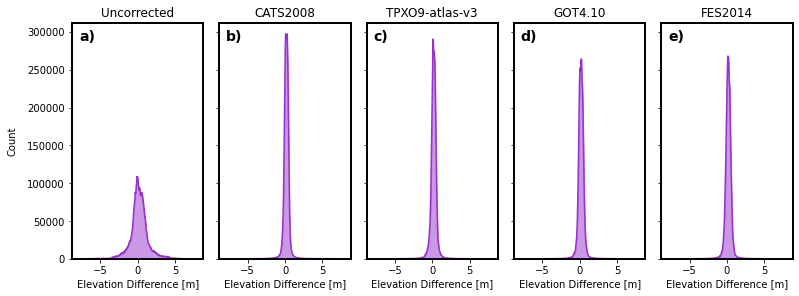

In [17]:
# figure axes for output histogram plots
fig,ax = plt.subplots(ncols=5, sharey=True, figsize=(11,4))
plot_labels = ['a)','b)','c)','d)','e)']

# output file of histogram statistics
args = ('ATL11',METHOD,REGION,RELEASE)
FILE = '{0}_{1}_{2}_TIDAL_HISTOGRAM_{3}.txt'.format(*args)
fid = open(os.path.join(base_dir,FILE),'w')
print('Histogram Statistics ({0})'.format(METHOD), file=fid)
print('Minimum: {0:0.2f}'.format(vmin), file=fid)
print('Maximum: {0:0.2f}'.format(vmax), file=fid)
print('Width: {0:0.2f}'.format(w), file=fid)
print('Bins: {0:d}'.format(nbins), file=fid)
# print total number of points for differencing method
print('All Cycles: {0:d}\n'.format(total_valid), file=fid)

# create histogram plots
for i,key in enumerate(['Uncorrected',*TIDE_MODELS]):
    # plot histograms
    ax[i].plot(b2,hist[key],color='darkorchid',lw=1.5)
    ax[i].fill_between(b2,hist[key],color='darkorchid',alpha=0.5)
    # set title
    ax[i].set_title(key)
    # Add figure label
    at = matplotlib.offsetbox.AnchoredText(plot_labels[i], loc=2, pad=0,
        frameon=False, prop=dict(size=14,weight='bold',color='k'))
    ax[i].axes.add_artist(at)
    # add x labels
    ax[i].set_xlabel('Elevation Difference [m]',labelpad=3)
    # calculate histogram statistics
    N = np.sum(hist[key])
    # histogram mean and standard deviation
    hmean = np.average(b2, weights=hist[key])
    hvariance = np.average((b2-hmean)**2, weights=hist[key])
    hstdev = np.sqrt(hvariance)
    # histogram skewness and excess kurtosis
    hskewness = np.average((b2-hmean)**3, weights=hist[key])/(hstdev**3)
    hkurtosis = np.average((b2-hmean)**4, weights=hist[key])/(hstdev**4)
    hkurtosis_excess = hkurtosis - 3.0
    # omnibus chi-squared test of normality
    mu1 = np.sqrt(6.0*N*(N-1.0)/(N-2.0)/(N+1.0)/(N+3.0))
    mu2 = 2.0*mu1*np.sqrt((N*N-1.0)/(N-3.0)/(N+5.0))
    chi2 = (hskewness/mu1)**2 + (hkurtosis_excess/mu2)**2
    pvalue = 1.0 - scipy.stats.chi2.cdf(chi2,2)
    # cumulative probability distribution function of histogram
    cpdf = np.cumsum(hist[key]/np.sum(hist[key]))
    # calculate percentiles for IQR and RDE
    # IQR: first and third quartiles (25th and 75th percentiles)
    # RDE: 16th and 84th percentiles
    # median: 50th percentile
    Q1,Q3,P16,P84,hmedian = np.interp([0.25,0.75,0.16,0.84,0.5],cpdf,b2)
    # calculate interquartile range (IQR)
    hIQR = 0.75*(Q3 - Q1)
    # calculate robust dispersion estimator (RDE)
    hRDE = 0.50*(P84 - P16)
    # print model to file
    print('{0}:'.format(key), file=fid)
    # print statistics to file
    print('\t{0}: {1:f}'.format('Mean',hmean), file=fid)
    print('\t{0}: {1:f}'.format('Median',hmedian), file=fid)
    print('\t{0}: {1:f}'.format('StDev',hstdev), file=fid)
    print('\t{0}: {1:f}'.format('Skewness',hskewness), file=fid)
    print('\t{0}: {1:f}'.format('Kurtosis',hkurtosis_excess), file=fid)
    # print('\t{0}: {1:f}'.format('Normal',pvalue), file=fid)
    # print median statistics to file
    print('\t{0}: {1:f}'.format('IQR',hIQR), file=fid)
    print('\t{0}: {1:f}'.format('RDE',hRDE), file=fid)
    # output file of histogram for model
    args = ('ATL11',METHOD,REGION,key,RELEASE)
    HIST = '{0}_{1}_{2}_{3}_TIDAL_HISTOGRAM_{4}.txt'.format(*args)
    fid1 = open(os.path.join(base_dir,HIST),'w')
    # for each histogram bin
    for bn,hst in zip(b2,hist[key]):
        print('{0:0.02f} {1:0.0f}'.format(bn,hst),file=fid1)
    # close model histogram file
    fid1.close()
# close statistics file
fid.close()

# add y labels
ax[0].set_ylabel('Count', labelpad=10)
# set ylimits
ymin,ymax = ax[0].get_ylim()
ax[0].set_ylim(0,ymax)
# adjust plot to figure dimensions
fig.subplots_adjust(left=0.07,right=0.98,top=0.93,bottom=0.11,
    wspace=0.12,hspace=0.20)
# output file format for each region type
args = ('ATL11',METHOD,REGION,RELEASE)
PLOT = '{0}_{1}_{2}_TIDAL_HISTOGRAM_{3}.pdf'.format(*args)
# save plot as png to the plot directory
print('\t--> {0}'.format(os.path.join(base_dir,PLOT)))
plt.savefig(os.path.join(base_dir,PLOT), format='pdf', dpi=720,
    metadata={'Title':os.path.basename(sys.argv[0])})